# CS 594 / CS 690 - Assignment 08
### October 22, 2018
---

For this assignment, you must work in groups of one or two students. Each person is responsible to write their own code, but the group will (together) discuss their solution.  In this notebook, we provide you with basic functions for completing the assignment.  *Complete the assignment in this notebook.  You will need to modify existing code and write new code to find a solution*.  Each member of the group must upload their own work (i.e., a notebook file) to GitHub.

*Note: Running a cell will not rerun previous cells.  If you edit code in previous cells, you must rerun those cells.  If you are having trouble with undefined errors and code changes not applying, we recommend using* `Run All` *to avoid any errors results from not rerunning previous cells.  You can find this in the menu above:* `Cell -> Run All`

Previously, we looked at food items reported in the dietary data from the National Health and Nutrition Examination Survey (NHANES).  As a reminder, NHANES is a cross-sectional survey that is conducted every two years in the United States. As part of the survey, individuals are asked to complete a demographics questionnaire and a 24-hour dietary recall. The 24-hour dietary recalls have been shown to be a valid and reliable method for describing usual dietary intakes of a population.  Given the tens of thousands of different foods an individual may report in the NHANES dietary recall data, it is beneficial to group (i.e., cluster) similar foods based on macronutrient and micronutrient content.  These food groups can be used to gain new insight into the dietary patterns of individuals and populations.  For example, if an individual eats only foods in the "high fat, low carbohydrate" group we may conclude that this individual is on the [ketogenic diet](https://en.wikipedia.org/wiki/Ketogenic_diet).

Last assignment, we provided data with food items and fat and carbohdryate contents of each food item.  You may have visually noticed that many of the food clusters (found with $k$-Means) were very close and not very distinct (i.e., well separated).  In this assignment, we provide raw NHANES dietary intake sample data from 2 years of the survey.  These data include many more values for each food item, including micronutrient content (e.g., minerals and vitamins) and metadata (e.g., person reporting the food and time of reporting).  The inclusion of all nutrient content values increases the dimensionality of the data (i.e., the number of values representing each food item is large) and should also produce more distinct clusters.  Given the high-dimensionality of the data, it seems appropriate to use a clustering algorithm more complex than the $k$-Means we have used in previous assignments.

In this assignment you will use [Density-based spatial clustering of applications with noise](https://en.wikipedia.org/wiki/DBSCAN) (DBSCAN) to cluster food items based on macronutrient and micronutrient content.  You learned about DBSCAN in today's lecture, but if you want to learn more, here is an [interactive DBSCAN model](https://www.naftaliharris.com/blog/visualizing-dbscan-clustering/).  We will reference the paper *[Development of a Scalable Method for Creating Food Groups Using the NHANES Dataset and MapReduce](https://dl.acm.org/citation.cfm?id=2975179)* (the ACM Digital Library is available through the University, but may not be available at home.  We have included the paper in this repo at `./paper.pdf`), which also used DBSCAN to cluster food items from the NHANES dataset.  You will use the data preprocessing code and the DBSCAN code provided in this paper's [git repo](https://github.com/TauferLab/NHANES-Analytics).

*You will need to preprocess the raw NHANES dietary data (located at `./data/NHANES-20**-dietary.csv`), cluster it with DBSCAN, and reproduce figure 6 from the "Development of a Scalable Method for Creating Food Groups Using the NHANES Dataset and MapReduce" paper.  Note: your figures may be slightly different because you are only using 2 years of NHANES data, where the paper used 7 years of data.*

We have isolated the relevant code from the paper, adapted it for this assignment, and included it in this repository.  If you would like to look at the source code, open the python files located in `./src/`, or visit the [git repo](https://github.com/TauferLab/NHANES-Analytics).  Below, we load a SparkContext and provide an example of how to load the NHANES dietary data, preprocess it, and cluster it.  Note that we also load a text file, `./data/features.txt` which contains the list of micro- and macronutrirent values we want from the raw NHANES data.  Use this code as a reference for how to use the provided preprocessing and clustering code.

In [1]:
# Note: If you are having trouble loading Spark, try uncommenting the following two lines
#import findspark
#findspark.init()

from pyspark import SparkContext
sc = SparkContext.getOrCreate()

# Load code from paper
from src.preprocess import cleanNHANESData
from src.DBSCAN import DBSCAN

# Load NHANES dietary data from 2009 and 2011
# The preprocessing code expects a dictionary with RDDs of NHANES dietary data
raw_data = {}
for year in ['2009', '2011']:
    raw_data[year] = sc.textFile('./data/NHANES-{}-dietary.csv'.format(year))
    
# Print total number of food item entries
total = 0
for year_data in raw_data.values():
    total += year_data.count()
print('Total number of food entries: {}'.format(total))
    
# Load list of nutrient features we want from the raw dietary data
with open('./data/features.txt') as f:
    features = f.readlines()
features = [f.strip() for f in features]

# Look at the list of features you will use for each food item
# We need this list because some features (i.e., values) in the raw NHANES data cannot be used to cluster
# Note that the first 4 features are:
# "USDA food code", "Respondent sequence number", "Modification code", and "Grams"
# The remaining features are micro- and macronutrient features
# HINT: ref [1]
print('List of features:\n', features)

Total number of food entries: 68500
List of features:
 ['DR1IFDCD', 'SEQN', 'DR1MC', 'DR1IGRMS', 'DR1IKCAL', 'DR1IPROT', 'DR1ICARB', 'DR1ISUGR', 'DR1IFIBE', 'DR1ITFAT', 'DR1ISFAT', 'DR1IMFAT', 'DR1IPFAT', 'DR1ICHOL', 'DR1IATOC', 'DR1IATOA', 'DR1IRET', 'DR1IVARA', 'DR1IACAR', 'DR1IBCAR', 'DR1ICRYP', 'DR1ILYCO', 'DR1ILZ', 'DR1IVB1', 'DR1IVB2', 'DR1INIAC', 'DR1IVB6', 'DR1IFOLA', 'DR1IFA', 'DR1IFF', 'DR1IFDFE', 'DR1ICHL', 'DR1IVB12', 'DR1IB12A', 'DR1IVC', 'DR1IVD', 'DR1IVK', 'DR1ICALC', 'DR1IPHOS', 'DR1IMAGN', 'DR1IIRON', 'DR1IZINC', 'DR1ICOPP', 'DR1ISODI', 'DR1IPOTA', 'DR1ISELE', 'DR1ICAFF', 'DR1ITHEO', 'DR1IALCO', 'DR1IMOIS', 'DR1IS040', 'DR1IS060', 'DR1IS080', 'DR1IS100', 'DR1IS120', 'DR1IS140', 'DR1IS160', 'DR1IS180', 'DR1IM161', 'DR1IM181', 'DR1IM201', 'DR1IM221', 'DR1IP182', 'DR1IP183', 'DR1IP184', 'DR1IP204', 'DR1IP205', 'DR1IP225', 'DR1IP226']


You may notice that the first four features are not related to nutrient values.  These features are used in the cleaning process and will be removed post-processing. 

Apply the pre-processing to the data!  You will notice that there are tens of thousands food item entries.  We are only interested in the unique food items (e.g., if a person reports *bread* twice, we only care about one instance of *bread*).

In [2]:
# Apply preprocessing code from paper
# This may take a minute!
clean_data = cleanNHANESData(sc, raw_data, features).persist()

# Look at cleaned NHANES dietary data
# Elements in RDD are key-value pairs of (food ID, np.array(nutrient value))
print ('Total unique food items: {}'.format(clean_data.count()))
print(clean_data.take(1))

Total unique food items: 3968


Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.runJob.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 23.0 failed 1 times, most recent failure: Lost task 0.0 in stage 23.0 (TID 90, localhost, executor driver): java.net.SocketException: Connection reset by peer: socket write error
	at java.net.SocketOutputStream.socketWrite0(Native Method)
	at java.net.SocketOutputStream.socketWrite(Unknown Source)
	at java.net.SocketOutputStream.write(Unknown Source)
	at java.io.BufferedOutputStream.write(Unknown Source)
	at java.io.DataOutputStream.write(Unknown Source)
	at java.io.FilterOutputStream.write(Unknown Source)
	at org.apache.spark.api.python.PythonRDD$.org$apache$spark$api$python$PythonRDD$$write$1(PythonRDD.scala:201)
	at org.apache.spark.api.python.PythonRDD$$anonfun$writeIteratorToStream$1.apply(PythonRDD.scala:213)
	at org.apache.spark.api.python.PythonRDD$$anonfun$writeIteratorToStream$1.apply(PythonRDD.scala:213)
	at scala.collection.Iterator$class.foreach(Iterator.scala:893)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at org.apache.spark.api.python.PythonRDD$.writeIteratorToStream(PythonRDD.scala:213)
	at org.apache.spark.api.python.PythonRunner$$anon$2.writeIteratorToStream(PythonRunner.scala:407)
	at org.apache.spark.api.python.BasePythonRunner$WriterThread$$anonfun$run$1.apply(PythonRunner.scala:215)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:1991)
	at org.apache.spark.api.python.BasePythonRunner$WriterThread.run(PythonRunner.scala:170)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1602)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1590)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1589)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1589)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:831)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:831)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:831)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:1823)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1772)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1761)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:642)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2034)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2055)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2074)
	at org.apache.spark.api.python.PythonRDD$.runJob(PythonRDD.scala:149)
	at org.apache.spark.api.python.PythonRDD.runJob(PythonRDD.scala)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(Unknown Source)
	at java.lang.reflect.Method.invoke(Unknown Source)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Unknown Source)
Caused by: java.net.SocketException: Connection reset by peer: socket write error
	at java.net.SocketOutputStream.socketWrite0(Native Method)
	at java.net.SocketOutputStream.socketWrite(Unknown Source)
	at java.net.SocketOutputStream.write(Unknown Source)
	at java.io.BufferedOutputStream.write(Unknown Source)
	at java.io.DataOutputStream.write(Unknown Source)
	at java.io.FilterOutputStream.write(Unknown Source)
	at org.apache.spark.api.python.PythonRDD$.org$apache$spark$api$python$PythonRDD$$write$1(PythonRDD.scala:201)
	at org.apache.spark.api.python.PythonRDD$$anonfun$writeIteratorToStream$1.apply(PythonRDD.scala:213)
	at org.apache.spark.api.python.PythonRDD$$anonfun$writeIteratorToStream$1.apply(PythonRDD.scala:213)
	at scala.collection.Iterator$class.foreach(Iterator.scala:893)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at org.apache.spark.api.python.PythonRDD$.writeIteratorToStream(PythonRDD.scala:213)
	at org.apache.spark.api.python.PythonRunner$$anon$2.writeIteratorToStream(PythonRunner.scala:407)
	at org.apache.spark.api.python.BasePythonRunner$WriterThread$$anonfun$run$1.apply(PythonRunner.scala:215)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:1991)
	at org.apache.spark.api.python.BasePythonRunner$WriterThread.run(PythonRunner.scala:170)


The data returned from `cleanNHANESData()` is an RDD of `(key, values)` where the keys are food item IDs (these uniquely identify each unique food item) and the values are micro- and macronutrient values!  Some of the nutrient values are negative.  This is because the nutrient values are [normalized and standardized](https://en.wikipedia.org/wiki/Normalization_%28statistics%29).  Now, apply the DBSCAN clustering below!  **This may take several minutes, depending on your machine!**

In [3]:
# Define DBSCAN parameters
epsilon = 1
min_pts = 4
metric = 'euclidean'

# Cluster the food items with DBSCAN
# This may take a few minutes, depending on your machine!
food_clusters = DBSCAN(sc, clean_data, epsilon=epsilon, minpts=min_pts, metric=metric)

# Look at the cluster results
# Elements in the RDD are key-value pairs of (food ID, cluster ID)
print('Clustered food items: {}'.format(food_clusters.count()))
print(food_clusters.take(1))

KeyboardInterrupt: 

The resulting RDD from DBSCAN contain `(key, value)` pairs.  The `key` is the ID of the food item in the cluster.  The `value` is the cluster ID.  This version of DBSCAN labels clusters by the food item with the *minimum* ID value in a cluster.  Last, you will see that the number of food items clustered is smaller than the total number of unique food items because DBSCAN removes *noise* (i.e., food items that are not similar to other food items).

### Problem 1:

Recreating Figure 6 from the paper should be accomplished in incremental steps.  Now that you know how to preprocess and cluster food items based on nutrient content using DBSCAN, you can develop metrics to report in the figure.  Figure 6 reports (1) the percentage of food items clustered and (2) the number of food clusters found.  *Define the functions below which intake food clusters (i.e., the output of DBSCAN) and returns percentage of food items clustered and number of food clusters found.*

In [ ]:
# Define a function to report the percent of total food items that are clustered
# The input 'clusters' should be the output of DBSCAN
# The input 'total' should be the total number of unique food items (before clustering)
# HINT: ref [2]
def percentClustered(clusters, total):
    return 100*clusters.count()/total
    
# Define a function to count the number of clusters
# The input 'clusters' should be the output of DBSCAN
# HINT: ref [2,3]
def clusterCount(clusters):
    return clusters.map(lambda x: x[1]).countDistinct()

Now use the functions you defined about to report the percent of food items clustered and the number of food clusters from the clusters you found above!

In [ ]:
# Apply the functions you defined to the clusters found above
perc_clust = percentClustered(food_clusters, clean_data.count())
clust_cnt = clusterCount(food_clusters)

# Print results
print('Food items clustered: {:.2f}%'.format(perc_clust))
print('Number of food clusters: {}'.format(clust_cnt))

**Sample Output:**

```
Food items clustered: 34.68%
Number of food clusters: 79
```

**References:**
- [1: NHANES 2011 Nutrient Labels](https://wwwn.cdc.gov/Nchs/Nhanes/2011-2012/DR1IFF_G.htm)
- [2: RDD.count](https://spark.apache.org/docs/2.1.0/api/python/pyspark.html?highlight=count#pyspark.RDD.count)
- [3: RDD.distinct](https://spark.apache.org/docs/2.1.0/api/python/pyspark.html?highlight=count#pyspark.RDD.distinct)

## Don't forget to shelve your Jetstream instance when you're not using it!

### Problem 2:

Now that you have a method to recreate the values found in Figures 6 of the paper, you must create a plotting script.  *Below, define a function that intakes a 2D array and plots a heatmap.*  We provide `dummy_data` for you to test your plotting method.  Remember, you should label the axes, provide the correct axes tick labels, and give the heatmap a title!

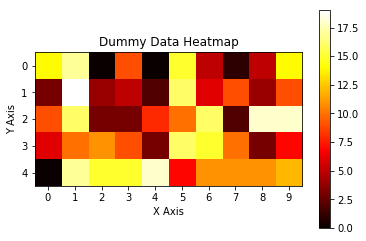

In [1]:
import numpy as np
from matplotlib import pyplot as plt

# define a class to help normalize heatmap scale
from matplotlib.colors import Normalize

class MidpointNormalize(Normalize):

    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

# Define a function that intake a 2D array of data values and plots a heatmap
# Make sure you include axes and tick labels as well as a color bar!
# HINT: ref [1,2,3]
def plotHeatMap(data, x_title='X Axis', y_title='Y Axis', title='', x_ticks=[], y_ticks=[]):
    vmin, midpoint = np.min(data), np.mean(data)
    plt.imshow(data, interpolation='nearest', cmap=plt.cm.hot, norm=MidpointNormalize(vmin=vmin, midpoint=midpoint))
    plt.xlabel(x_title)
    plt.ylabel(y_title)
    plt.colorbar()
    plt.xticks(np.arange(len(x_ticks)), x_ticks)
    plt.yticks(np.arange(len(y_ticks)), y_ticks)
    plt.title(title)
    plt.show()
    plt.clf()

# Test plotting function with dummy data
dummy_data = np.random.randint(20, size=(5,10))
plotHeatMap(dummy_data, x_ticks=range(10), y_ticks=range(5), title='Dummy Data Heatmap')

For reference, your heatmap should look similar to this:
<img src="./sample_heatmap.png">

**References:**
- [1: pyplot.pcolor](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.pcolor.html)
- [2: Making a heatmap with pcolor example](https://stackoverflow.com/questions/14391959/heatmap-in-matplotlib-with-pcolor)
- [3: pyplot.colorbar](https://matplotlib.org/api/colorbar_api.html)

## Don't forget to shelve your Jetstream instance when you're not using it!

### Problem 3:

Now that you have methods for calculating the values in Figure 6 from the paper and a method to plot the values, you can recreate the figure!  **To save time, you will recreate a figure similar to Figure 6 in the paper, but with only 30% of the the data.** 

In [ ]:
# Sample 30% of the original data
clean_data_sample = clean_data.sample(False, 0.30).persist()

*In the cell below, cluster food items with the euclidean distance metric and `epsilon` and `min_pts` values in ranges $[2,4]$ and $[4,7]$, respectively.  Plot two heatmaps.  One heatmap should show the percentage of food items clustered and the second heatmap should show the number of clusters found.*  Note: We use values for `epsilon` and `min_pts` that are different than those in the paper because we are using a smaller, less dense dataset.  The figures you make will be different than Figure 6 from the paper.  In the cell below, we provide two arrays.  Fill these arrays with the appropriate values and use them to create your heatmaps.  **This may take several minutes, depending on your machine!**

In [ ]:
# Define the distance metric we want to use
metric = 'euclidean'

# Test each combination of epsilon and minpts value in the ranges defined above!
# Fill each of the numpy arrays below with the correct values for epsilon i and min_pts j
# For example, when epsilon is 4 and min_pts is 5, enter values in array location [2,1]
hm_per_data = np.zeros((3, 4))
hm_count_data = np.zeros((3, 4))

# Created nested for loops to enumerate each combination of epsilon and min_pts value
# Record the percentage of food items clustered and the number of clusters
# We reccommend you use print statements to see the progress!
for i, epsilon in enumerate(range(2, 5)):
    for j, min_pts in enumerate(range(4, 8)):
        print("Clustering with epsilon = ", epsilon, " and min_pts = ", min_pts, " . . .")
      food_clusters = DBSCAN(sc, clean_data, epsilon=epsilon, minpts=min_pts, metric=metric)
        perc_clust = percentClustered(food_clusters, clean_data.count())
        clust_cnt = clusterCount(food_clusters)
        print('Food items clustered: {:.2f}%'.format(perc_clust))
        print('Number of food clusters: {}'.format(clust_cnt))
        hm_per_data[i, j] = perc_clust
        hm_count_data[i, j] = clust_cnt
        
# Plot the results in heatmaps
plotHeatMap(hm_per_data, y_title='epsilon', x_title='min_pts',\
            title='Percent Food Items Clustered', y_ticks=range(2,5), x_ticks=range(4,8))
plotHeatMap(hm_count_data, y_title='epsilon', x_title='min_pts',\
            title='Numer of Food Clusters', y_ticks=range(2,5), x_ticks=range(4,8))  


## Don't forget to shelve your Jetstream instance when you're not using it!

### Problem 4:

While we cannot visualize the 40+ dimensions of nutrient data present, we can project the data (and clusters) down to 2 dimensions and visualize the clusters.  Select an `epsilon` and `min_pts` values that you think clusters the food items best (based on your heatmaps in Problem 3).  *Define values for `epsilon` and `min_pts` in the cell below and examine the resulting clusters.  Try different values for the DBSCAN input parameters and see how the clusters change!*  Below we provide code to cluster the data with DBSCAN and project the nutrient values to 2 Dimensions for visual assessment.

In [ ]:
from sklearn.manifold import TSNE

# Projects and plots high dimensional food clusters to a 2D axis
# Input: clusters: RDD <<(cluster ID, [nutrient, values]), (cluster ID, [nutrient, values]), ...>>
# Return: None (shows a plot)
def plotFoodClusters2D(clusters):
    # Get cluster IDS to color plotted clusters
    cluster_ids = clusters.keys().collect()
    unique_ids = np.unique(cluster_ids).tolist()
    cluster_ids = [unique_ids.index(i) for i in cluster_ids]
    
    # Reduce nutrient values to 2 dimensions with TSNE
    # HINT: ref [1,2]
    nutrient_values = clusters.values().collect()
    cluster_embedded = TSNE(n_components=2).fit_transform(nutrient_values)
    
    # Plot clusters
    X = cluster_embedded[:,0]
    Y = cluster_embedded[:,1]
    plt.scatter(X, Y, c=cluster_ids, s=3)
    plt.show()
    plt.clf()
    
    
# Define your values for epsilon and min_pts
#epsilon = 
#min_pts = 
metric = 'euclidean'

# Cluster the food items with your parameters and DBSCAN
food_clusters = DBSCAN(sc, clean_data_sample, epsilon=epsilon, minpts=min_pts, metric=metric)

# Combine cluster ID with nutrient value
# RDD is now << (food ID, (cluster ID, [nutrient, values])), (food ID, (cluster ID, [nutrient, values])), ...>>
cluster_data = food_clusters.join(clean_data_sample)

# Isolate cluster ID and nutrient value (i.e., get rid of food item ID)
# RDD should be <<(cluster ID, [nutrient, values]), (cluster ID, [nutrient, values]), ...>>
cluster_nutrient = cluster_data.values()

# Plot clusters in 2D projected space and report cluster information
plotFoodClusters2D(cluster_nutrient)
perc_clust = percentClustered(food_clusters, clean_data_sample.count())
clust_cnt = clusterCount(food_clusters)
print('{} Clusters found with {:.2f} % food items clustered'.format(clust_cnt, perc_clust))

**References:**
- [1: TSNE Algorithm](https://lvdmaaten.github.io/tsne/)
- [2: sklearn's TSNE](http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)

## Don't forget to shelve your Jetstream instance when you're not using it!

### Problem 5:

For this assignment and previous assignments we have been using [Euclidean distance](https://en.wikipedia.org/wiki/Euclidean_distance), but this distance metric can suffer from the [Curse of Dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality).  Other distance metrics may be better suited for this high-dimensional NHANES food data, such as [Cosine Similarity](https://en.wikipedia.org/wiki/Cosine_similarity).  Below, we provide code that clusters the food items with DBSCAN using the *Cosine Similarity* metric.  Examine the clusters found using DBSCAN and *Cosine Similarity*, then answer the following questions.

In [ ]:
# Define values for epsilon and min_pts
epsilon = 0.1
min_pts = 4
metric = 'cosine'

# Cluster the food items with your parameters and DBSCAN
food_clusters = DBSCAN(sc, clean_data_sample, epsilon=epsilon, minpts=min_pts, metric=metric)

# Combine cluster ID with nutrient value
cluster_data = food_clusters.join(clean_data_sample)

# Isolate cluster ID and nutrient value (i.e., get rid of food item ID)
cluster_nutrient = cluster_data.values()

# Plot clusters in 2D projected space and report cluster information
plotFoodClusters2D(cluster_nutrient)
perc_clust = percentClustered(food_clusters, clean_data_sample.count())
clust_cnt = clusterCount(food_clusters)
print('{} Clusters found with {:.2f} % food items clustered'.format(clust_cnt, perc_clust))

**Compare the clusters you found during last assignment with $k$-means and only two macronutrients to the cluster you found with DBSCAN and all the macronutrients and micronutrients.  What differences do you notice?  Which do you think is better, and why?**

*Your answers here*

**In Problem 4, you chose an `epsilon` and `min_pts` value based on the heatmaps you created in Problem 3.  What was your motivation for choosing these values?**

*Your answers here*

**In this assignment, you clustered food items using DBSCAN with the Euclidean distance metric and Cosine Similarity.  What differences did you notice?  Which do you believe is better, and why?**

*Your answers here*

**DBSCAN can only find clusters of a certain density, based on the `epsilon` and `min_pts` value provided.  However, some datasets may contain clusters with different densities.  How could the DBSCAN algorithm be improved for data containing clusters of different densities?**

*Your answers here*

### Things to Consider:
Many machine learning tasks have labeled data which indicates if a model correctly predicts an outcome.  With clustering, there are typically no labels for the datasets.  How can we be sure that our clusters are good?

### Assignment Questions:
**Answer the following questions, in a couple sentences each, in the cells provided below**
* List the key tasks you accomplished during this assignment?
* Describe the challenges you faced in addressing these tasks and how you overcame these challenges?
* Did you work with other students on this assignment? If yes, how did you help them? How did they help you? Be as specific as possible.

*Your answers here*

## Don't forget to shelve your Jetstream instance when you're not using it!

### Project

**It is time to answer these key questions for your project:** 
* What is your dataset?

I will be using the "Sentiment140" dataset that comprises 1.6 million tweets (<https://www.kaggle.com/kazanova/sentiment140>).

* What are the scientific question(s) that you want to answer in your project? 

What are the key topics that people have been talking about on Twitter, and how have people's attitudes changed about these topics over time? Is it possible to predict people's sentiments on these topics going forward?

* What is the (tentative) methodology? Are you clustering, or classifying? How can you look for solutions in an efficient and distrbuted way?

I will use LDA to find the most important topics. Using the sentiment labels of the tweets, I will plot the proportion of positive tweets over time for each topic. Based on the observed trends, I will choose a regression model to predict sentiment over time for each topic.

* What are the metrics of success?

I will be looking for trends in sentiment over time. I will fit a regression model for each topic and apply it on a test set. If I get good prediction on the test set, then I can conclude that it is possible to predict the attidues of people as a function of time on each topic.

* What are the milestones you want to meet from now until Dec 3 when you will present your poster at the poster showcase?

	1. The dataset is too big for this project. I will plot a histogram of tweet time stamps as well as sentiments to pick a reasonable subset of the data to work with-- one that is small enough to work with but also has patterns that can be useful.
	2. I will preprocess the text-- throw out stop words, handle punctuation, etc. I will then format the tweets as a TFIDF matrix.
	3. I will perform LDA.
	4. I will assign a sentiment score to each topic for each month in the data.
	5. I will perform regression on sentiments over time for each topic and look for trends.

